In [23]:
xfile = 'F:\workspace\j6stock\XOpenHighLowCloseVol_tp10_cl10.txt'
lstm_size = 120         # 3 times the amount of channels
lstm_layers = 2        # Number of layers
batch_size = 2048       # Batch size
learning_rate = 0.001  #0.0001  # Learning rate (default is 0.001)
epochs = 40

# Fixed
#amount_of_features_cvs = 5 # cvs with prefix with feature column
#n_channels = amount_of_features
seq_len = lstm_size
y_column = 6

In [24]:
import tensorflow as tf
from sklearn import preprocessing
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import pandas_datareader.data as web
import h5py
import os
from keras import backend as K

In [25]:
def get_stock_data(normalize=True, ma=[]):
    """
    Return a dataframe of that stock and normalize all the values. 
    (Optional: create moving average)
    """
    df = pd.read_csv(filepath_or_buffer  = xfile )
    #TODO Use previous close instead of open
    df['change'] = df['close'] - df['open']
    for i, row in df.iterrows():
        df.at[i, 'high'] = df.at[i, 'high'] - (df.at[i, 'open'] if df.at[i, 'open'] > df.at[i, 'close'] else df.at[i, 'close'])
        df.at[i, 'low'] = (df.at[i, 'close'] if df.at[i, 'close'] < df.at[i, 'open'] else df.at[i, 'open']) - df.at[i, 'low']
    df.dropna(inplace=True)
    df = df.drop('open', axis=1)
    # Moving Average    
    if ma != []:
        for moving in ma:
            df['{}ma'.format(moving)] = df['close'].rolling(window=moving).mean()
    df.dropna(inplace=True)
    if normalize:
        min_max_scaler = preprocessing.MinMaxScaler()
        #df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
        df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
        df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
        #df['vol'] = min_max_scaler.fit_transform(df.vol.values.reshape(-1,1))
        df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
        #df['change'] = min_max_scaler.fit_transform(df['change'].values.reshape(-1,1))
        if ma != []:
            for moving in ma:
                df['{}ma'.format(moving)] = min_max_scaler.fit_transform(df['{}ma'.format(moving)].values.reshape(-1,1))  
    df.dropna(inplace=True)
               
    # Move y_result to the rightmost for the ease of training
    adj_close = df['y_result']
    df.drop(labels=['y_result'], axis=1, inplace=True)
    df = pd.concat([df, adj_close], axis=1)
      
    return df

In [26]:
df = get_stock_data( ma=[50, 100, 200])
amount_of_features = len(df.columns)-1

In [27]:
def plot_stock(df):
    print(df.head())
    plt.subplot(211)
    plt.plot(df['close'], color='red', label='Close')
    plt.legend(loc='best')
    plt.subplot(212)
    plt.plot(df['change'], color='blue', label='Percentage change')
    plt.legend(loc='best')
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(df['high'], color='red', label='high')
    ax1.legend(loc='best')
 
    ax2.plot(df['low'], color='red', label='low')
    ax2.legend(loc='best')
    plt.show()

             high           low     close    change      50ma     100ma  \
199  4.445337e-14  6.182380e-03  0.357085 -0.000150  0.351429  0.351070   
200  2.002002e-03  1.545595e-02  0.356606 -0.000060  0.351433  0.351063   
201  1.301301e-02  7.727975e-03  0.356893  0.000035  0.351445  0.351060   
202  4.445337e-14  1.545595e-03  0.357133  0.000015  0.351502  0.351082   
203  6.006006e-03  6.863821e-14  0.358138  0.000095  0.351587  0.351141   

        200ma  y_result  
199  0.346428         0  
200  0.346426         0  
201  0.346424         0  
202  0.346433         0  
203  0.346448         0  


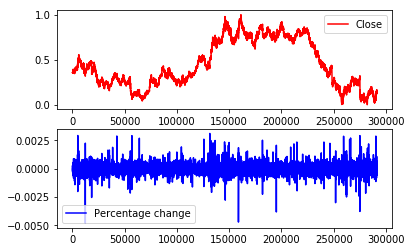

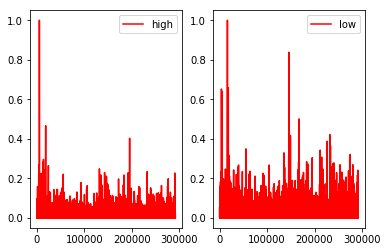

In [28]:
plot_stock(df)

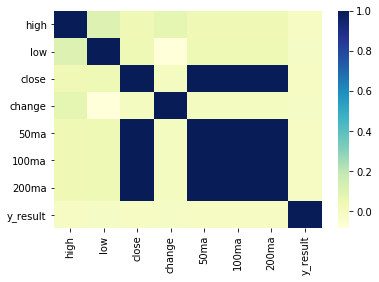

In [29]:
corr = df.corr()
ax = sns.heatmap(corr, cmap="YlGnBu")
plt.show()

In [30]:
def load_data(stock, seq_len):
    print ("Amount of features = {}".format(amount_of_features))
    data = stock.as_matrix()
    sequence_length = seq_len + 1 # index starting from 0
    x_result = []
    y_result = []
    for index in range(seq_len, len(data) ): # maxmimum date = lastest date - sequence length
        x_result.append(data[index-seq_len: index,:-1]) # index : index + 22days
        y_result.append(data[index ,amount_of_features]);

    #print('---', data[0])
    #print('---', x_result[0])
    #print('---', y_result[0])
    x_result = np.array(x_result)
    y_result = np.array(y_result)
    row = round(0.6 * y_result.shape[0]) # 80% split
    print ("Amount of training data = {}".format(0.9 * x_result.shape[0]))
    print ("Amount of testing data = {}".format(0.1 * y_result.shape[0]))
     
    X_train = x_result[:int(row), :] # 90% date
    y_train = y_result[:int(row)] # 90% date
        

    X_test = x_result[int(row):, :]
    y_test = y_result[int(row):]
    # filter for 1 and -1 for validation only
    X_test = X_test[y_test[:]!=0,:]
    y_test = y_test[y_test[:]!=0]
    #print(result.shape[0], len(y_result), int(row), y_result[int(row):])
    #X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features-1))
    #X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features-1))
    
    return [X_train, y_train, X_test, y_test]

In [31]:
lb = preprocessing.LabelBinarizer()
lb.fit([1, 0, -1])

X_tr, lab_tr, X_vld, lab_vld = load_data(df, seq_len)
y_tr = lb.transform(lab_tr)
y_vld = lb.transform(lab_vld)
print(X_tr.shape, lab_tr.shape, X_vld.shape, lab_vld.shape)
print(amount_of_features)

Amount of features = 7
Amount of training data = 261918.9
Amount of testing data = 29102.100000000002
(174613, 120, 7) (174613,) (70626, 120, 7) (70626,)
7


In [32]:
def get_batches(X, y, batch_size = 100):
	""" Return a generator for batches """
	n_batches = len(X) // batch_size
	X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

	# Loop over batches and yield
	for b in range(0, len(X), batch_size):
		yield X[b:b+batch_size], y[b:b+batch_size]

In [33]:
graph = tf.Graph()
n_channels = amount_of_features
n_classes = lb.transform([1]).shape[1]
# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Construct inputs to LSTM

In [34]:
with graph.as_default():
    # Construct the LSTM inputs and LSTM cells
    lstm_in = tf.transpose(inputs_, [1,0,2]) # reshape into (seq_len, N, channels)
    lstm_in = tf.reshape(lstm_in, [-1, n_channels]) # Now (seq_len*N, n_channels)
    
    # To cells
    lstm_in = tf.layers.dense(lstm_in, lstm_size, activation=None) # or tf.nn.relu, tf.nn.sigmoid, tf.nn.tanh?
    
    # Open up the tensor into a list of seq_len pieces
    lstm_in = tf.split(lstm_in, seq_len, 0)
    
    # Add LSTM layers
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob_)
    cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)
    initial_state = cell.zero_state(batch_size, tf.float32)

Define forward pass, cost function and optimizer:

In [35]:
with graph.as_default():
    outputs, final_state = tf.contrib.rnn.static_rnn(cell, lstm_in, dtype=tf.float32,
                                                     initial_state = initial_state)
    
    # We only need the last output tensor to pass into a classifier
    logits = tf.layers.dense(outputs[-1], n_classes, name='logits')
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    #optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost) # No grad clipping
    
    # Grad clipping
    train_op = tf.train.AdamOptimizer(learning_rate_)

    gradients = train_op.compute_gradients(cost)
    capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients]
    optimizer = train_op.apply_gradients(capped_gradients)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [36]:
if (os.path.exists('checkpoints') == False):
    !mkdir checkpoints

In [37]:
interation_compute_val = 1
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    saver.restore(sess, "checkpoints/har-lstm.ckpt")
    for e in range(epochs):
        # Initialize 
        state = sess.run(initial_state)
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, 
                    initial_state : state, learning_rate_ : learning_rate}
            
            loss, _ , state, acc = sess.run([cost, optimizer, final_state, accuracy], 
                                             feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 25 iterations
            if (iteration%interation_compute_val == 50):
                
                # Initiate for validation set
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                
                val_acc_ = []
                val_loss_ = []
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0, initial_state : val_state}
                    
                    # Loss
                    loss_v, state_v, acc_v = sess.run([cost, final_state, accuracy], feed_dict = feed)
                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints/har-lstm.ckpt")

INFO:tensorflow:Restoring parameters from checkpoints/har-lstm.ckpt
Epoch: 0/40 Iteration: 5 Train loss: 1.058858 Train acc: 0.506348
Epoch: 0/40 Iteration: 10 Train loss: 1.052129 Train acc: 0.475586
Epoch: 0/40 Iteration: 15 Train loss: 1.107546 Train acc: 0.367188
Epoch: 0/40 Iteration: 20 Train loss: 1.078643 Train acc: 0.416016
Epoch: 0/40 Iteration: 25 Train loss: 1.126991 Train acc: 0.326172
Epoch: 0/40 Iteration: 30 Train loss: 1.032156 Train acc: 0.493652
Epoch: 0/40 Iteration: 35 Train loss: 0.961228 Train acc: 0.579102
Epoch: 0/40 Iteration: 40 Train loss: 0.924035 Train acc: 0.604004
Epoch: 0/40 Iteration: 45 Train loss: 1.059852 Train acc: 0.380859
Epoch: 0/40 Iteration: 50 Train loss: 0.848794 Train acc: 0.628418
Epoch: 0/40 Iteration: 55 Train loss: 1.032425 Train acc: 0.485352
Epoch: 0/40 Iteration: 60 Train loss: 1.126640 Train acc: 0.379883
Epoch: 0/40 Iteration: 65 Train loss: 1.038600 Train acc: 0.380859
Epoch: 0/40 Iteration: 70 Train loss: 1.074003 Train acc: 0.41

Epoch: 7/40 Iteration: 605 Train loss: 0.980884 Train acc: 0.534668
Epoch: 7/40 Iteration: 610 Train loss: 1.075289 Train acc: 0.416016
Epoch: 7/40 Iteration: 615 Train loss: 1.034746 Train acc: 0.477539
Epoch: 7/40 Iteration: 620 Train loss: 1.115293 Train acc: 0.343262
Epoch: 7/40 Iteration: 625 Train loss: 1.009637 Train acc: 0.516602
Epoch: 7/40 Iteration: 630 Train loss: 0.896720 Train acc: 0.603516
Epoch: 7/40 Iteration: 635 Train loss: 0.886248 Train acc: 0.643555
Epoch: 7/40 Iteration: 640 Train loss: 1.054854 Train acc: 0.437500
Epoch: 7/40 Iteration: 645 Train loss: 0.836556 Train acc: 0.631836
Epoch: 7/40 Iteration: 650 Train loss: 0.947765 Train acc: 0.566406
Epoch: 7/40 Iteration: 655 Train loss: 1.132820 Train acc: 0.355957
Epoch: 7/40 Iteration: 660 Train loss: 1.001625 Train acc: 0.377441
Epoch: 7/40 Iteration: 665 Train loss: 1.040430 Train acc: 0.420898
Epoch: 7/40 Iteration: 670 Train loss: 0.959271 Train acc: 0.489746
Epoch: 7/40 Iteration: 675 Train loss: 1.097620 

Epoch: 14/40 Iteration: 1200 Train loss: 0.970160 Train acc: 0.491211
Epoch: 14/40 Iteration: 1205 Train loss: 1.082734 Train acc: 0.426270
Epoch: 14/40 Iteration: 1210 Train loss: 1.039167 Train acc: 0.451172
Epoch: 14/40 Iteration: 1215 Train loss: 1.107078 Train acc: 0.361816
Epoch: 14/40 Iteration: 1220 Train loss: 1.000864 Train acc: 0.507812
Epoch: 14/40 Iteration: 1225 Train loss: 0.905203 Train acc: 0.607910
Epoch: 14/40 Iteration: 1230 Train loss: 0.882327 Train acc: 0.637695
Epoch: 14/40 Iteration: 1235 Train loss: 1.039935 Train acc: 0.458008
Epoch: 14/40 Iteration: 1240 Train loss: 0.845789 Train acc: 0.619629
Epoch: 14/40 Iteration: 1245 Train loss: 0.945307 Train acc: 0.554688
Epoch: 14/40 Iteration: 1250 Train loss: 1.118347 Train acc: 0.342773
Epoch: 14/40 Iteration: 1255 Train loss: 0.998973 Train acc: 0.377930
Epoch: 14/40 Iteration: 1260 Train loss: 1.023999 Train acc: 0.419434
Epoch: 14/40 Iteration: 1265 Train loss: 0.967579 Train acc: 0.461426
Epoch: 14/40 Iterati

Epoch: 21/40 Iteration: 1790 Train loss: 0.987844 Train acc: 0.501465
Epoch: 21/40 Iteration: 1795 Train loss: 0.972503 Train acc: 0.480469
Epoch: 21/40 Iteration: 1800 Train loss: 1.054276 Train acc: 0.458496
Epoch: 21/40 Iteration: 1805 Train loss: 1.034586 Train acc: 0.465332
Epoch: 21/40 Iteration: 1810 Train loss: 1.123697 Train acc: 0.359375
Epoch: 21/40 Iteration: 1815 Train loss: 1.001211 Train acc: 0.515137
Epoch: 21/40 Iteration: 1820 Train loss: 0.906226 Train acc: 0.602051
Epoch: 21/40 Iteration: 1825 Train loss: 0.900086 Train acc: 0.632324
Epoch: 21/40 Iteration: 1830 Train loss: 1.028977 Train acc: 0.469238
Epoch: 21/40 Iteration: 1835 Train loss: 0.874916 Train acc: 0.610840
Epoch: 21/40 Iteration: 1840 Train loss: 0.949008 Train acc: 0.564453
Epoch: 21/40 Iteration: 1845 Train loss: 1.123219 Train acc: 0.343262
Epoch: 21/40 Iteration: 1850 Train loss: 1.001001 Train acc: 0.364746
Epoch: 21/40 Iteration: 1855 Train loss: 1.017622 Train acc: 0.411133
Epoch: 21/40 Iterati

Epoch: 27/40 Iteration: 2380 Train loss: 1.055927 Train acc: 0.443359
Epoch: 28/40 Iteration: 2385 Train loss: 0.969215 Train acc: 0.499023
Epoch: 28/40 Iteration: 2390 Train loss: 0.973519 Train acc: 0.480469
Epoch: 28/40 Iteration: 2395 Train loss: 1.049386 Train acc: 0.463379
Epoch: 28/40 Iteration: 2400 Train loss: 1.015094 Train acc: 0.493164
Epoch: 28/40 Iteration: 2405 Train loss: 1.108462 Train acc: 0.370605
Epoch: 28/40 Iteration: 2410 Train loss: 0.995318 Train acc: 0.515625
Epoch: 28/40 Iteration: 2415 Train loss: 0.909043 Train acc: 0.604004
Epoch: 28/40 Iteration: 2420 Train loss: 0.888425 Train acc: 0.640137
Epoch: 28/40 Iteration: 2425 Train loss: 1.030447 Train acc: 0.458008
Epoch: 28/40 Iteration: 2430 Train loss: 0.851944 Train acc: 0.618652
Epoch: 28/40 Iteration: 2435 Train loss: 0.942339 Train acc: 0.569336
Epoch: 28/40 Iteration: 2440 Train loss: 1.127757 Train acc: 0.326172
Epoch: 28/40 Iteration: 2445 Train loss: 0.994332 Train acc: 0.374512
Epoch: 28/40 Iterati

Epoch: 34/40 Iteration: 2970 Train loss: 1.062463 Train acc: 0.438965
Epoch: 34/40 Iteration: 2975 Train loss: 1.042440 Train acc: 0.457031
Epoch: 35/40 Iteration: 2980 Train loss: 0.959520 Train acc: 0.513672
Epoch: 35/40 Iteration: 2985 Train loss: 0.970488 Train acc: 0.484375
Epoch: 35/40 Iteration: 2990 Train loss: 1.051049 Train acc: 0.461914
Epoch: 35/40 Iteration: 2995 Train loss: 1.006967 Train acc: 0.502930
Epoch: 35/40 Iteration: 3000 Train loss: 1.099099 Train acc: 0.366699
Epoch: 35/40 Iteration: 3005 Train loss: 0.975896 Train acc: 0.528320
Epoch: 35/40 Iteration: 3010 Train loss: 0.899523 Train acc: 0.599609
Epoch: 35/40 Iteration: 3015 Train loss: 0.871551 Train acc: 0.635254
Epoch: 35/40 Iteration: 3020 Train loss: 1.026854 Train acc: 0.457031
Epoch: 35/40 Iteration: 3025 Train loss: 0.843923 Train acc: 0.613281
Epoch: 35/40 Iteration: 3030 Train loss: 0.941518 Train acc: 0.580566
Epoch: 35/40 Iteration: 3035 Train loss: 1.128229 Train acc: 0.338379
Epoch: 35/40 Iterati

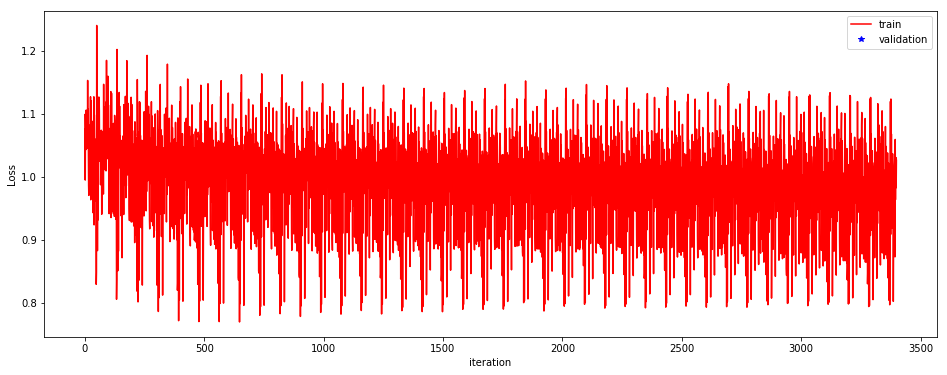

In [38]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (16,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % interation_compute_val == 50], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

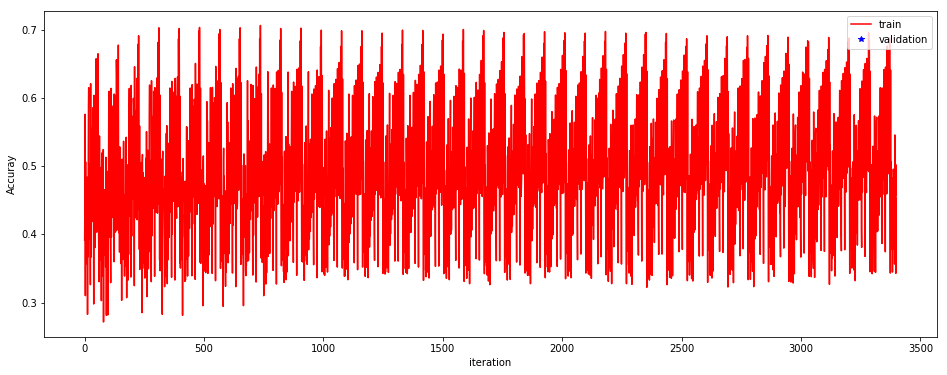

In [39]:

# Plot Accuracies# Plot A 
plt.figure(figsize = (16,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % interation_compute_val == 50], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Evaluate on test set

In [40]:
test_acc = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    print(y_vld.shape)
    for x_t, y_t in get_batches(X_vld, y_vld, batch_size):        
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1,
                initial_state: test_state}
        
        batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
        test_acc.append(batch_acc)
        print(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints\har-lstm.ckpt
(70626, 3)
0.414063
0.463867
0.350586
0.325195
0.417969
0.34375
0.411133
0.358887
0.384766
0.297852
0.318848
0.484863
0.349609
0.3125
0.344238
0.356445
0.329102
0.443359
0.283203
0.416992
0.379883
0.318359
0.36084
0.296875
0.361816
0.404297
0.36377
0.256836
0.427246
0.372559
0.325684
0.389648
0.395996
0.346191
Test accuracy: 0.364918


In [41]:

a = np.array([[ 0,  1,  2,  0,  4,  5,  6,  7,  8,  10],
              [ 0, 11,  0, 13,  0, 15,  0, 17, 18,  0]])
print (a[a.max(axis=1) >= 10])


[[ 0  1  2  0  4  5  6  7  8 10]
 [ 0 11  0 13  0 15  0 17 18  0]]


In [42]:

a = np.array([[ 0,  1,  2,  0,  4,  5,  6,  7,  8,  9],
              [ 0, 11,  0, 13,  0, 15,  0, 17, 18,  0]])
print (a[a[:,2]!=0])

[[0 1 2 0 4 5 6 7 8 9]]


In [43]:
print(ytest[:]!=0)
Xtest = np.array([[ 0,  1,  2,  0,  4,  5,  6,  7,  8,  9],
              [ 0, 11,  0, 13,  0, 15,  0, 17, 18,  0],
             [ 0, 11,  0, 13,  0, 15,  0, 11, 1,  1]])
ytest = np.array([ 0,  1,  1])
Xtest = Xtest[ytest[:]!=0,:]
ytest = ytest[ytest[:]!=0]
print(Xtest)
print(ytest)

NameError: name 'ytest' is not defined